# Comparison of Computing `traceinv` with Various Methods (Analytic Matrix)


### Objective

Compares $\mathrm{trace}(\mathbf{A}^{-1})$ using three algorithms:

* **SLQ**: stochastic numerical solution, all 32-bit, 64-bit, and 128-bit data type.
* **Hutchinson**: stochastic numerical solution, only for 32-bit, 64-bit data type.
* **Cholesky**: direct numerical solution, only 64-bit data type.

Matrix $\mathbf{A}$ is a sparse 3-band matrix with known analytic traceinv. Matrix size is varied by powers of two.

This notebook will plot

* Process time of each method.
* Accuracy of computing traceinv when compared with analytic solution for this matrix.

### Matrix

Matrix $\mathbf{A} = \mathbf{C}^{\intercal} \mathbf{C}$ is a symmetric 3-band matrix and $\mathbf{C}$ is a 2-band matrix defined by

$$
    C_{ij} = 
    \begin{cases}
        \alpha, & i = j, \\
        \beta, & i+1 = j.
    \end{cases}
$$

The analytic value of $\mathrm{trace}(\mathbf{A}^{-1})$ is known by

$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{1}{\alpha^2 - \beta^2} \left( n - q^2 \frac{q^{2n} - 1}{q^2 - 1} \right),
$$
where $n$ is the size of the matrix and $q = \beta / \alpha \neq 1$. If $n \gg 1$
$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{1}{\alpha^2 - \beta^2} \left( n - \frac{q^{2}}{1 - q^2} \right).
$$
If $q = 1$, then
$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{n (n+1)}{2 \alpha^2}.
$$

### Consideratons

**parameters:**
* $\alpha = 2$, $\beta = 1$
* In SLQ and Hutchinson methods, `min_num_samples` and `max_num_samples` are fixed to 200.
* In SLQ method, `lanczos_degree` is 30.
* All 24 cores of Intel Xeon E5-2670 v3 processor are used for all algorithms.
* For SLQ and Hutchinson methods, each result is repeated 10 times and the wall time is averaged between these 10 repeats. However, only the last repeat is used to store the value of traceinv. This is becase if we average traceinv between these repeats, the number of samples would be 10*200, not 200. But, we onlt want to show the error of traceinv for 200 samples.
* Cholesky method is not repeated, since it is not a stochatic method and it runtime is more-or-less very similar in each test.
* The results of all three methods are compared with the analytic value of traceinv given in the above.

**Notes:**

* Matrix is generated as sparse CSR.
* Matrix size varies on powers of two. Chlesky method is only used for matrices smaller or equal to $2^{14}$ in size.
* SLQ method computes all 32, 64, and 128 but data types.
* Hutchinson method computes only 32 and 64 bit data types.
* Cholesky method computes only 53-bit data type using *sparsesuite* package. (If we used scipy's cholesky decompostion, instead of sparsesuite, we could have computed both 32-bit and 64-bit data types).

### How to run the code

#### 1. Run locally

Run `/benchmark/scripts/compare_methods_analytic_matrix.py` by

    cd /benchmark/scripts
    python ./compare_methods_analytic_matrix.py -a -f traceinv
    
where `-a` will generate all 32-bit, 64-bit, and 128-bit results. Also, `-f` determines which function to compute. The script can compute both traceinv and logdet.
        
The output is stored in `/benchnmark/pickle_results/compare_methods_analytic_matrix_traceinv.pickle`.

#### 2. Run on cluster

To run this script on a cluster with SLURM:

    cd jobfiles
    sbatch jobfile_compare_methods_analytic_matrix_traceinv.sh
   
When submitting the jobs, make sure that the cpu is the same as the previous runs. For isnatnce, nodes on savio2 cluster between `n027` and `n150` are *Intel Xeon E5-2670 v3*.

In [1]:
import imate
import numpy
import numpy.polynomial.polynomial as poly
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

# Plot savefig settings
extension = 'png'
transparent=True
dpi = 500

#matplotlib.rcParams['text.antialiased'] = True
#matplotlib.rcParams['lines.antialiased'] = True
#matplotlib.rcParams['patch.antialiased'] = True

In [2]:
benchmark_dir = '..'
results_filename = join(benchmark_dir, 'pickle_results', 'compare_methods_analytic_matrix_traceinv.pickle')


with open(results_filename, 'rb') as file:
    benchmark_results = pickle.load(file)
    
print('Config:')
pp.pprint(benchmark_results['config'])

print('')
print('Matrix:')
pp.pprint(benchmark_results['matrix'])

print('')
print('Devices:')
pp.pprint(benchmark_results['devices'])

print('')
print('Date:')
pp.pprint(benchmark_results['date'])

print('')
print('num data results (32-bit): %d' % len(benchmark_results['data_results-32bit']))
print('num data results (64-bit): %d' % len(benchmark_results['data_results-64bit']))
print('num data results (128-bit): %d' % len(benchmark_results['data_results-128bit']))

Config:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'lanczos_degree': 30,
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_repeats': 10,
    'num_threads': 0,
    'orthogonalize': 0,
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'symmetric': True,
    'verbose': False}

Matrix:
{   'band_alpha': 2.0,
    'band_beta': 1.0,
    'format': 'csr',
    'max_cholesky_size': 8192,
    'max_hutchinson_size': 4194304,
    'sizes': array([      16,       32,       64,      128,      256,      512,
           1024,     2048,     4096,     8192,    16384,    32768,
          65536,   131072,   262144,   524288,  1048576,  2097152,
        4194304,  8388608, 16777216, 33554432]),
    'symmetric': True}

Devices:
{   'cpu_name': 'Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz',
    'num_all_cpu_threads': 24}

Date:
'08/08/2021 12:26:20'

num data results (32-bit): 22
nu

In [3]:
def find_slope(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    return numpy.polyfit(log2_x, log2_y, 1)[0]


def log_line_fit(xi, x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_xi = numpy.log2(xi)
    log2_y = numpy.log2(y)
    
    coefs = poly.polyfit(log2_x, log2_y, 1)
    log2_yi = poly.polyval(log2_xi, coefs)
    
    return 2**log2_yi


def analytic_traceinv(matrix):
    """
    Analytic trace of inverse of banded matrix.
    """
    
    sizes = matrix['sizes']
    alpha = matrix['band_alpha']
    beta = matrix['band_beta']
    symmetric = matrix['symmetric']
    
    if symmetric:
        
        if alpha == beta:
            M_traceinv = sizes * (sizes+1) / (2.0 * alpha**2)
        else:
            q = beta / alpha
            M_traceinv = numpy.zeros((sizes.size), dtype=float)
            
            for i in range(sizes.size):
                if sizes[i] < 200:
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * \
                        ( sizes - (q**2) *((q**(2.0*sizes) - 1.0) / (q**2 - 1.0)))
                else:
                    # Using assymptitic approximation of large sums
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * ( sizes - ((q**2) / (1.0 - q**2)))
            
    else:
        M_traceinv = sizes / alpha
        
    return M_traceinv

Plot saved to "compare_methods_analytic_matrix_traceinv_time.png".


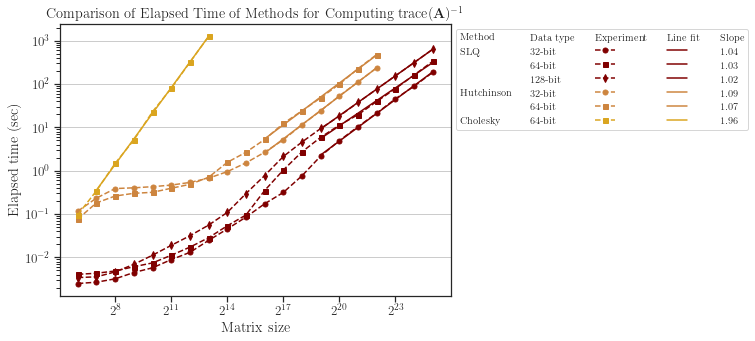

In [4]:
sizes = benchmark_results['matrix']['sizes']

# Id set to True, plots cpu_proc time. If set to False, plots alg_wall_time
plot_cpu_proc_time = False

num_sizes = sizes.size
num_types = 3
trace_s = numpy.zeros((num_types, num_sizes), dtype=float)
trace_h = numpy.zeros((num_types, num_sizes), dtype=float)
trace_c = numpy.zeros((num_types, num_sizes), dtype=float)
error_s = numpy.zeros((num_types, num_sizes), dtype=float)
error_h = numpy.zeros((num_types, num_sizes), dtype=float)
alg_wall_time_s = numpy.zeros((num_types, num_sizes), dtype=float)
alg_wall_time_h = numpy.zeros((num_types, num_sizes), dtype=float)
alg_wall_time_c = numpy.zeros((num_types, num_sizes), dtype=float)
cpu_proc_time_s = numpy.zeros((num_types, num_sizes), dtype=float)
cpu_proc_time_h = numpy.zeros((num_types, num_sizes), dtype=float)
cpu_proc_time_c = numpy.zeros((num_types, num_sizes), dtype=float)

trace_c[:] = numpy.nan
alg_wall_time_h[:] = numpy.nan
cpu_proc_time_h[:] = numpy.nan
alg_wall_time_c[:] = numpy.nan
cpu_proc_time_c[:] = numpy.nan

fig, ax = plt.subplots(figsize=(7, 5))

result_type_names = ['data_results-32bit', 'data_results-64bit', 'data_results-128bit']

lighten = [1, 0.8, 0.6]
color_s = 'maroon'
color_h = 'peru'
color_c = 'goldenrod'
markerfacecolor_s = ['maroon', 'maroon', 'maroon']
markeredgecolor_s = ['maroon', 'maroon', 'maroon']
markersize_s = numpy.array([5, 5, 5])
markersize_h = numpy.array([5, 5, 5])
markersize_c = numpy.array([5, 5, 5])
marker_type_s = ['--o', '--s', '--d']
marker_type_h = ['--o', '--s', '--d']
marker_type_c = ['--o', '--s', '--d']

slope_s = numpy.zeros((num_types, ), dtype=float)
slope_h = numpy.zeros((num_types, ), dtype=float)
slope_c = numpy.zeros((num_types, ), dtype=float)

# Start index of the plots
start_index = 2

# For trace and errors, use the last entry ([-1]). For alg_wall_time, use the mean of the array.
for k in range(len(result_type_names)):
    for i in range(num_sizes):
        data_results = benchmark_results[result_type_names[k]]
        trace_s[k, i] = data_results[i]['trace_s'][-1]

        if not numpy.isscalar(data_results[i]['trace_h']):
            trace_h[k, i] = data_results[i]['trace_h'][-1]
        else:
            trace_h[k, i] = data_results[i]['trace_h']
        trace_c[k, i] = data_results[i]['trace_c']
        error_s[k, i] = data_results[i]['info_s']['error']['absolute_error'][-1]

        if data_results[i]['info_h'] != {}:
            error_h[k, i] = data_results[i]['info_h']['error']['absolute_error'][-1]
        else:
            error_h[k, i] = numpy.nan
        alg_wall_time_s[k, i] = numpy.mean(data_results[i]['info_s']['time']['alg_wall_time'])
        cpu_proc_time_s[k, i] = numpy.mean(data_results[i]['info_s']['time']['cpu_proc_time'])

        if data_results[i]['info_h'] != {}:
            alg_wall_time_h[k, i] = numpy.mean(data_results[i]['info_h']['time']['alg_wall_time'])
            cpu_proc_time_h[k, i] = numpy.mean(data_results[i]['info_h']['time']['cpu_proc_time'])
        else:
            alg_wall_time_h[k, i] = numpy.nan
        if not numpy.isnan(trace_c[k, i]):
            alg_wall_time_c[k, i] = data_results[i]['info_c']['time']['tot_wall_time']
            cpu_proc_time_c[k, i] = data_results[i]['info_c']['time']['cpu_proc_time']

    #ax.plot(sizes, alg_wall_time_s, '--o', color=lighten_color(color_s, lighten[k]), label='SLQ')
    #ax.plot(sizes, alg_wall_time_h, '--s', color=lighten_color(color_h, lighten[k]), label='Hutchinson')
    #ax.plot(sizes, alg_wall_time_c, '--d', color=lighten_color(color_c, lighten[k]), label='Cholesky')
    
    # SLQ (32-bit, 64-bit, and 128-bit)
    if plot_cpu_proc_time:
        ax.plot(sizes[start_index:], cpu_proc_time_s[k, start_index:], marker_type_s[k], color=color_s,
            markerfacecolor=markerfacecolor_s[k], markersize=markersize_s[k], label='SLQ')
    else:
        ax.plot(sizes[start_index:], alg_wall_time_s[k, start_index:], marker_type_s[k], color=color_s,
                markerfacecolor=markerfacecolor_s[k], markersize=markersize_s[k], label='SLQ')
    
    # Slope
    if plot_cpu_proc_time:
        slope_s[k] = find_slope(sizes[-4:], cpu_proc_time_s[k, -4:])
    else:
        slope_s[k] = find_slope(sizes[-4:], alg_wall_time_s[k, -4:])
    
    # Interpolation
    sizes_s_i = numpy.logspace(numpy.log2(sizes[-7]), numpy.log2(sizes[-1]), 100, base=2)
    if plot_cpu_proc_time:
        cpu_proc_time_s_i = log_line_fit(sizes_s_i, sizes[-7:], cpu_proc_time_s[k, -7:])
        ax.plot(sizes_s_i, cpu_proc_time_s_i, '-', color=color_s,
                label='linear fit, slope: %0.2f' % slope_s[k])
    else:
        alg_wall_time_s_i = log_line_fit(sizes_s_i, sizes[-7:], alg_wall_time_s[k, -7:])
        ax.plot(sizes_s_i, alg_wall_time_s_i, '-', color=color_s,
                label='linear fit, slope: %0.2f' % slope_s[k])
    
    # Hutchinson (32-bit and 64-bit only)
    if result_type_names[k] != 'data_results-128bit':
        if plot_cpu_proc_time:
            ax.plot(sizes[start_index:], cpu_proc_time_h[k, start_index:], marker_type_h[k], color=color_h,
                    markersize=markersize_h[k], label='Hutchinson')
        else:
            ax.plot(sizes[start_index:], alg_wall_time_h[k, start_index:], marker_type_h[k], color=color_h,
                    markersize=markersize_h[k], label='Hutchinson')
        
        # Slope
        if plot_cpu_proc_time:
            slope_h[k] = find_slope(sizes[-10:-3], cpu_proc_time_h[k, -10:-3])
        else:
            slope_h[k] = find_slope(sizes[-10:-3], alg_wall_time_h[k, -10:-3])
            
        # Interpolation
        sizes_h_i = numpy.logspace(numpy.log2(sizes[-10]), numpy.log2(sizes[-4]), 100, base=2)
        if plot_cpu_proc_time:
            cpu_proc_time_h_i = log_line_fit(sizes_h_i, sizes[-10:-3], cpu_proc_time_h[k, -10:-3])

            ax.plot(sizes_h_i, cpu_proc_time_h_i, '-', color=color_h,
                    label='linear fit, slope: %0.2f' % slope_h[k])
        else:
            alg_wall_time_h_i = log_line_fit(sizes_h_i, sizes[-10:-3], alg_wall_time_h[k, -10:-3])

            ax.plot(sizes_h_i, alg_wall_time_h_i, '-', color=color_h,
                    label='linear fit, slope: %0.2f' % slope_h[k])
        
    # Cholesky Method (64-bit only)
    if result_type_names[k] == 'data_results-64bit':
        if plot_cpu_proc_time:
            ax.plot(sizes[start_index:], cpu_proc_time_c[k, start_index:], marker_type_c[k], color=color_c,
                    markersize=markersize_c[k], label='Cholesky')
        else:
            ax.plot(sizes[start_index:], alg_wall_time_c[k, start_index:], marker_type_c[k], color=color_c,
                    markersize=markersize_c[k], label='Cholesky')

        # Slopes   
        if plot_cpu_proc_time:
            slope_c[k] = find_slope(sizes[3:9], cpu_proc_time_c[k, 3:9])
        else:
            slope_c[k] = find_slope(sizes[3:9], alg_wall_time_c[k, 3:9])

        # Interpolation
        sizes_c_i = numpy.logspace(numpy.log2(sizes[3]), numpy.log2(sizes[9]), 100, base=2)
        if plot_cpu_proc_time:
            cpu_proc_time_c_i = log_line_fit(sizes_c_i, sizes[3:10], cpu_proc_time_c[k, 3:10])
            ax.plot(sizes_c_i, cpu_proc_time_c_i, '-', color=color_c,
                    label='linear fit, slope: %0.2f' % slope_c[k])
        else:
            alg_wall_time_c_i = log_line_fit(sizes_c_i, sizes[3:10], alg_wall_time_c[k, 3:10])
            ax.plot(sizes_c_i, alg_wall_time_c_i, '-', color=color_c,
                    label='linear fit, slope: %0.2f' % slope_c[k])

plt.xscale('log', base=2)
plt.yscale('log', base=10)

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.set_xticks(cpu_num_cores)

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
handles = [extra, extra, extra, extra, extra, extra, extra,
           extra, extra, extra, extra, extra, extra, extra,
           extra, handles[0], handles[4], handles[10], handles[2], handles[6], handles[8],
           extra, handles[1], handles[5], handles[11], handles[3], handles[7], handles[9],
          extra, extra, extra, extra, extra, extra, extra]
labels = ["Method", "SLQ", "", "", "Hutchinson", "", "Cholesky",
          "Data type", "32-bit", "64-bit", "128-bit", "32-bit", "64-bit", "64-bit",
          "Experiment", "", "", "", "", "", "",
          "Line fit", "", "", "", "", "", "", 
          "Slope", '%0.2f' % slope_s[0], '%0.2f' % slope_s[1], '%0.2f' % slope_s[2],
          '%0.2f' % slope_h[0], '%0.2f' % slope_h[1], '%0.2f' % slope_c[1]]
ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=5, handletextpad = -2,
          fontsize='x-small')

if plot_cpu_proc_time:
    ax.set_ylabel('Process time (sec)')
    ax.set_title('Comparison of Process Time of Methods for Computing $\mathrm{trace}(\mathbf{A})^{-1}$')
else:
    ax.set_ylabel('Elapsed time (sec)')
    ax.set_title('Comparison of Elapsed Time of Methods for Computing $\mathrm{trace}(\mathbf{A})^{-1}$')
    
#ax.set_xlim([sizes[start_index], sizes[-1]])

ax.set_xlabel('Matrix size')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
filename_svg = 'compare_methods_analytic_matrix_traceinv_time' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg))

plt.show()

Plot saved to "compare_methods_analytic_matrix_traceinv_accuracy.png".


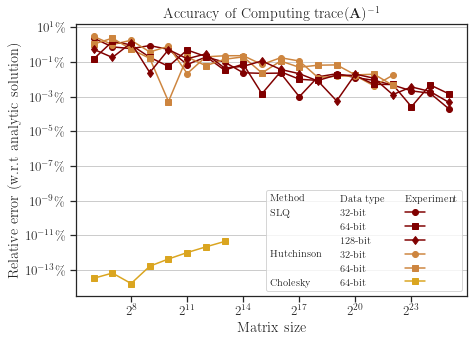

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))

trace = analytic_traceinv(benchmark_results['matrix'])
zero_errors = numpy.zeros_like(trace)


relative_error_s = numpy.zeros((num_types, num_sizes), dtype=float)
relative_error_h = numpy.zeros((num_types, num_sizes), dtype=float)
relative_error_c = numpy.zeros((num_types, num_sizes), dtype=float)
relative_error_error_s = numpy.zeros((num_types, num_sizes), dtype=float)
relative_error_error_h = numpy.zeros((num_types, num_sizes), dtype=float)

marker_type_s = ['-o', '-s', '-d']
marker_type_h = ['-o', '-s', '-d']
marker_type_c = ['-o', '-s', '-d']

for k in range(len(result_type_names)):
    
    # SLQ (32-bit, 64-bit, and 128-bit)
    relative_error_s[k, :] = numpy.abs((trace_s[k, :] - trace) / trace) * 100.0
    relative_error_error_s[k, :] = numpy.abs(error_s[k, :] / trace)
    
    ax.plot(sizes[start_index:], relative_error_s[k, start_index:], marker_type_s[k], color=color_s,
            label='SLQ')
    #ax.errorbar(sizes[start_index:], relative_error_s[k, start_index:], yerr=[zero_errors,
    #            relative_error_error_s[k, :]], fmt=marker_type_s[k], color=color_s, label='SLQ')
    
    # Hutchinson (32-bit and 64-bit only)
    if result_type_names[k] != 'data_results-128bit':
        relative_error_h[k, :] = numpy.abs((trace_h[k, :] - trace) / trace) * 100.0
        relative_error_error_h[k, :] = numpy.abs(error_h[k, :] / trace)
        
        ax.plot(sizes[start_index:], relative_error_h[k, start_index:], marker_type_h[k], color=color_h,
                label='Hutchinson')
        #ax.errorbar(sizes[start_index:], relative_error_h[k, start_index:], yerr=[zero_errors,
        #            relative_error_error_h[k, :]], fmt=marker_type_h[k], color=color_h, label='Hutchinson')
        
    # Cholesky Method (64-bit only)
    if result_type_names[k] == 'data_results-64bit':
        relative_error_c[k, :] = numpy.abs((trace_c[k, :] - trace) / trace) * 100.0
        
        ax.plot(sizes[start_index:], relative_error_c[k, start_index:], marker_type_c[k], color=color_c,
                label='Cholesky')

plt.xscale('log', base=2)
plt.yscale('log', base=10, nonpositive='clip')
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$10^{%d}\%%$' % numpy.log10(x)))

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.set_xticks(cpu_num_cores)
#ax.set_ylim([1e-16, 1e1])

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
handles = [extra, extra, extra, extra, extra, extra, extra,
           extra, extra, extra, extra, extra, extra, extra,
           extra, handles[0], handles[2], handles[5], handles[1], handles[3], handles[4]]
           #extra, handles[1], handles[5], handles[11], handles[3], handles[7], handles[9],
           #extra, extra, extra, extra, extra, extra, extra]
labels = ["Method", "SLQ", "", "", "Hutchinson", "", "Cholesky",
          "Data type", "32-bit", "64-bit", "128-bit", "32-bit", "64-bit", "64-bit",
          "Experiment", "", "", "", "", "", ""]
          #"Line fit", "", "", "", "", "", "",
          #"Slope", '%0.2f' % slope_s[0], '%0.2f' % slope_s[1], '%0.2f' % slope_s[2],
          #'%0.2f' % slope_h[0], '%0.2f' % slope_h[1], '%0.2f' % slope_c[1]]
#ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=3, handletextpad = -2,
#          fontsize='small')
ax.legend(handles, labels, loc='lower right', ncol=3, handletextpad = -2, fontsize='x-small')
#ax.set_xlim([sizes[start_index], sizes[-1]])

ax.set_title(r'Accuracy of Computing $\mathrm{trace}(\mathbf{A})^{-1}$')

ax.set_xlabel('Matrix size')
ax.set_ylabel('Relative error (w.r.t analytic solution)')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
filename_svg = 'compare_methods_analytic_matrix_traceinv_accuracy' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg))

plt.show()